<a href="https://colab.research.google.com/github/mannmoshe/text-recognition/blob/main/real_text_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real text detection

By Moshe Mann

In [1]:
import requests
import pandas as pd
import random

In [2]:
req = requests.get("https://raw.githubusercontent.com/mannmoshe/text-recognition/main/torah_heb.txt")
req.encoding = 'ISO-8859-8'
torah_text = req.text

In [3]:
torah_text = torah_text.replace('ם','מ').replace('ן','נ').replace('ץ','צ').replace('ף','פ').replace('ך','כ')

In [4]:
torah_words = torah_text.split()

## Createing dataset of real and random phrases so that the model will be able to detect real text.

In [5]:
phrases = {}
for i in range(0, int(len(torah_words)), 3):
  phrase = ''.join(torah_words[i: i+3])
  phrases[phrase] = 1 # true text
  phrase_letters_list = [l for l in phrase]
  random.Random(4).shuffle(phrase_letters_list) 
  # Random(4) for same result every time, see https://stackoverflow.com/questions/19306976/python-shuffling-with-a-parameter-to-get-the-same-result
  phrases[''.join(phrase_letters_list)] = 0 # random text

In [6]:
phrases_dataset = pd.DataFrame.from_dict(phrases, orient='index').reset_index()

In [7]:
phrases_dataset.columns = ['text', 'label']

In [8]:
phrases_dataset.shape

(48974, 2)

In [9]:
phrases_dataset.head(10)

,text,label
0,בראשיתבראאלהימ,1
1,איתאמלבהארבריש,0
2,אתהשמימואת,1
3,אהאומתיתמש,0
4,הארצוהארצהיתה,1
5,תיצההההרראאוצ,0
6,תהוובהווחשכ,1
7,והושתחכוהבו,0
8,עלפניתהומ,1
9,לפהומתעינ,0


In [10]:
X = phrases_dataset['text']
y = phrases_dataset['label']

Split the dataset to train and text

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4, stratify=y)

In [12]:
len(x_train)

32812

In [13]:
len(x_test)

16162

In [14]:
len(x_train) + len(x_test)

48974

## Prepare data for model

In [15]:
train_samples = x_train.tolist()
test_samples = x_test.tolist()

In [16]:
import numpy as np
from keras.preprocessing.text import Tokenizer

In [17]:
# We create a tokenizer, configured to only take
# into account the top-10000 most common words
#tokenizer = Tokenizer(num_words=10000, char_level=True) # char_level = True --> token by letters
tokenizer = Tokenizer(char_level=True) # char_level = True --> token by letters
# This builds the word index
tokenizer.fit_on_texts(train_samples)

# This turns strings into lists of integer indices.
train_sequences = tokenizer.texts_to_sequences(train_samples)
test_sequences = tokenizer.texts_to_sequences(test_samples)

# You could also directly get the one-hot binary representations.
# Note that other vectorization modes than one-hot encoding are supported!
x_train = tokenizer.texts_to_matrix(train_samples, mode='binary')
x_test = tokenizer.texts_to_matrix(test_samples, mode='binary')

# This is how you can recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22 unique tokens.


In [18]:
word_index

{'י': 1,
 'ו': 2,
 'ה': 3,
 'א': 4,
 'מ': 5,
 'ל': 6,
 'ת': 7,
 'ר': 8,
 'ב': 9,
 'ש': 10,
 'נ': 11,
 'כ': 12,
 'ע': 13,
 'ח': 14,
 'ד': 15,
 'ק': 16,
 'פ': 17,
 'צ': 18,
 'ז': 19,
 'ג': 20,
 'ס': 21,
 'ט': 22}

In [19]:
train_samples[:10]

['ישחמתמאשותיחמ',
 'יהיהבומומ',
 'רהשיזקממכרש',
 'מכלוהתאפס',
 'קברואתאביו',
 'במספרשמתמבנ',
 'תשמעונאתהמשפטימ',
 'ארהוחומרקוארצ',
 'שלירככאיפובלמ',
 'הבממוובשאחלרמת']

In [20]:
train_sequences[:10]

[[1, 10, 14, 5, 7, 5, 4, 10, 2, 7, 1, 14, 5],
 [1, 3, 1, 3, 9, 2, 5, 2, 5],
 [8, 3, 10, 1, 19, 16, 5, 5, 12, 8, 10],
 [5, 12, 6, 2, 3, 7, 4, 17, 21],
 [16, 9, 8, 2, 4, 7, 4, 9, 1, 2],
 [9, 5, 21, 17, 8, 10, 5, 7, 5, 9, 11],
 [7, 10, 5, 13, 2, 11, 4, 7, 3, 5, 10, 17, 22, 1, 5],
 [4, 8, 3, 2, 14, 2, 5, 8, 16, 2, 4, 8, 18],
 [10, 6, 1, 8, 12, 12, 4, 1, 17, 2, 9, 6, 5],
 [3, 9, 5, 5, 2, 2, 9, 10, 4, 14, 6, 8, 5, 7]]

In [21]:
lens = [len(s) for s in train_sequences]
lens[:20]

[13, 9, 11, 9, 10, 11, 15, 13, 13, 14, 12, 10, 14, 14, 10, 13, 11, 8, 11, 10]

In [22]:
sum(lens)/len(lens)

11.49652566134341

In [23]:
train_sequences[:10]

[[1, 10, 14, 5, 7, 5, 4, 10, 2, 7, 1, 14, 5],
 [1, 3, 1, 3, 9, 2, 5, 2, 5],
 [8, 3, 10, 1, 19, 16, 5, 5, 12, 8, 10],
 [5, 12, 6, 2, 3, 7, 4, 17, 21],
 [16, 9, 8, 2, 4, 7, 4, 9, 1, 2],
 [9, 5, 21, 17, 8, 10, 5, 7, 5, 9, 11],
 [7, 10, 5, 13, 2, 11, 4, 7, 3, 5, 10, 17, 22, 1, 5],
 [4, 8, 3, 2, 14, 2, 5, 8, 16, 2, 4, 8, 18],
 [10, 6, 1, 8, 12, 12, 4, 1, 17, 2, 9, 6, 5],
 [3, 9, 5, 5, 2, 2, 9, 10, 4, 14, 6, 8, 5, 7]]

In [24]:
max_len = 12
x_train_embedding = []

for s in train_sequences:
  if len(s) >= 12:
    x_train_embedding.append(s[:12])
  else:
    x_train_embedding.append(s + [0]*(max_len-len(s)))

x_train_embedding = np.array(x_train_embedding)

In [25]:
x_test_embedding = []

for s in test_sequences:
  if len(s) >= 12:
    x_test_embedding.append(s[:12])
  else:
    x_test_embedding.append(s + [0]*(max_len-len(s)))

x_test_embedding = np.array(x_test_embedding)

In [26]:
y_train = y_train.to_numpy()

In [27]:
y_train

array([0, 1, 0, ..., 0, 0, 0])

In [28]:
x_train_embedding

array([[ 1, 10, 14, ...,  7,  1, 14],
       [ 1,  3,  1, ...,  0,  0,  0],
       [ 8,  3, 10, ...,  8, 10,  0],
       ...,
       [ 1,  9,  6, ..., 12,  0,  0],
       [ 5,  1, 10, ..., 11,  9,  0],
       [ 8,  3,  4, ..., 11,  0,  0]])

Model building

In [29]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import SimpleRNN, Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [31]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=max_len))
model.add(LSTM(64, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(64))

model.compile(optimizer='rmsprop',
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.add(Dense(1, activation="sigmoid"))
model.summary()

history = model.fit(x_train_embedding, 
                    y_train,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.33)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 12, 8)             80000     
                                                                 
 lstm_1 (LSTM)               (None, 12, 64)            18688     
                                                                 
 dropout (Dropout)           (None, 12, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 12, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 12, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                

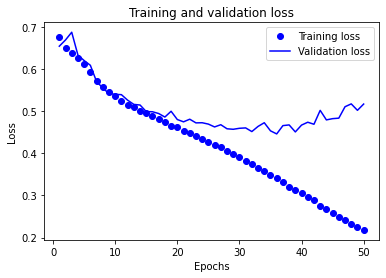

In [123]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

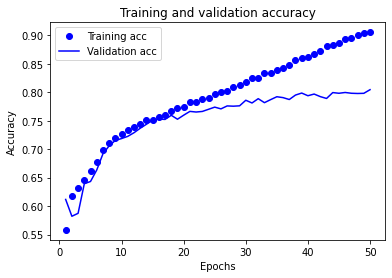

In [124]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Prepare output file for the test-set predictions

In [32]:
x_train[0]

array([0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [33]:
predicted_labels = model.predict(x_test_embedding)

506/506 [==============================] - 5s 8ms/step


In [34]:
print(type(predicted_labels),type(y_test))

<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [35]:
predicted_labels

array([[9.6520305e-01],
       [4.8268253e-01],
       [9.9979401e-01],
       ...,
       [9.9983138e-01],
       [4.3277934e-04],
       [9.4766641e-01]], dtype=float32)

In [36]:
my_list = map(lambda x: x[0], predicted_labels)
predictions = pd.Series(my_list)

In [37]:
len(predictions)

16162

In [38]:
len(y_test)

16162

In [39]:
predictions

0        0.965203
1        0.482683
2        0.999794
3        0.857719
4        0.418789
           ...   
16157    0.002373
16158    0.000190
16159    0.999831
16160    0.000433
16161    0.947666
Length: 16162, dtype: float32

In [40]:
y_test_ri = y_test.reset_index() 

In [41]:
y_test_ri

,index,label
0,15542,1
1,14953,0
2,20832,1
3,20498,1
4,1782,1
...,...,...
16157,26075,0
16158,27721,0
16159,36666,1
16160,41767,0


In [42]:
predictions_temp = pd.concat([predictions, y_test_ri], axis=1)

In [43]:
predictions_temp.head()

,0,index,label
0,0.965203,15542,1
1,0.482683,14953,0
2,0.999794,20832,1
3,0.857719,20498,1
4,0.418789,1782,1


In [44]:
x_train_orig, x_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.33, random_state=4, stratify=y)

In [45]:
x_test_orig

15542      מאדמועדבהמה
14953       דכמיהכטטנו
20832      ואכלואתמאשר
20498    ומשחתאתמומלאת
1782        עשבנתתילכמ
             ...      
26075    הנמוגיותלבאחה
27721      ישחתעאולללו
36666      הארצכיידעתי
41767     רתושוואיתאצמ
12782       מזקנלאיוכל
Name: text, Length: 16162, dtype: object

In [46]:
x_test_orig.reset_index().head()

,index,text
0,15542,מאדמועדבהמה
1,14953,דכמיהכטטנו
2,20832,ואכלואתמאשר
3,20498,ומשחתאתמומלאת
4,1782,עשבנתתילכמ


In [47]:
output_df = predictions_temp.merge(x_test_orig.reset_index(), how='inner', left_on='index', right_on='index')

In [48]:
output_df.head()

,0,index,label,text
0,0.965203,15542,1,מאדמועדבהמה
1,0.482683,14953,0,דכמיהכטטנו
2,0.999794,20832,1,ואכלואתמאשר
3,0.857719,20498,1,ומשחתאתמומלאת
4,0.418789,1782,1,עשבנתתילכמ


In [49]:
output_df['prediction'] = output_df[0].round(0).astype('int')

In [50]:
output_df.head()

,0,index,label,text,prediction
0,0.965203,15542,1,מאדמועדבהמה,1
1,0.482683,14953,0,דכמיהכטטנו,0
2,0.999794,20832,1,ואכלואתמאשר,1
3,0.857719,20498,1,ומשחתאתמומלאת,1
4,0.418789,1782,1,עשבנתתילכמ,0


In [51]:
sum(output_df['label'] == output_df['prediction']) / len(output_df['label']) # accuracy

0.8121519613909169

In [52]:
test1 = output_df.copy()

In [53]:
confusion_matrix = pd.crosstab(test1['label'], test1['prediction'], rownames=['Actual'], colnames=['Predicted'])

In [54]:
confusion_matrix

Predicted,0,1
Actual,,
0,6615,1466
1,1570,6511


In [55]:
test1.rename(columns={0: "prediction_probability"}, inplace=True)

In [56]:
test1.columns

Index(['prediction_probability', 'index', 'label', 'text', 'prediction'], dtype='object')

In [57]:
test1_output = test1[['text', 'label', 'prediction', 'prediction_probability']]

In [58]:
test1_output.head()

,text,label,prediction,prediction_probability
0,מאדמועדבהמה,1,1,0.965203
1,דכמיהכטטנו,0,0,0.482683
2,ואכלואתמאשר,1,1,0.999794
3,ומשחתאתמומלאת,1,1,0.857719
4,עשבנתתילכמ,1,0,0.418789


In [125]:
from google.colab import files

test1_output.to_csv('RNNtest1.csv', index=False ,encoding = 'utf-8-sig') 
files.download('RNNtest1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Apply the model on skipped text.

In [94]:
req = requests.get("https://github.com/mannmoshe/text-recognition/raw/main/torah_skips_of_2.txt")
#req.encoding = 'ISO-8859-8'
torah_skips_of_2 = req.text.replace('ם','מ').replace('ן','נ').replace('ץ','צ').replace('ף','פ').replace('ך','כ')

In [95]:
torah_skips_of_2[:10]

'באיבאליאהמ'

In [96]:
phrases_12 = {}

for i in range(0, len(torah_skips_of_2) - 12, 12):
  word = torah_skips_of_2[i:i + 12]
  phrases_12[word] = [i*2, i*2 + 12]

In [97]:
phrases_12_df = pd.DataFrame.from_dict(dict(phrases_12.items()), orient='index').reset_index()

In [98]:
phrases_12_df.columns = ['text', 'start_index', 'end_index']

In [99]:
phrases_12_df.head()

,text,start_index,end_index
0,באיבאליאהממא,0,12
1,הרואציההוהוש,24,36
2,עפיהמרחלימחת,48,60
3,לנהיוארליייו,72,84
4,והאריאליאהוכ,96,108


In [100]:
phrases_12_df.shape

(12671, 3)

In [101]:
X = phrases_12_df['text']

In [102]:
X_samples = X.tolist()

In [103]:
X_samples[:10]

['באיבאליאהממא',
 'הרואציההוהוש',
 'עפיהמרחלימחת',
 'לנהיוארליייו',
 'והאריאליאהוכ',
 'טבידאהמיהווי',
 'השוקאלילוימל',
 'שקאיהיירוהבר',
 'ואדימאהמהריב',
 'והיוהמדלימממ']

In [104]:
type(X_samples)

list

In [105]:
X_sequences = tokenizer.texts_to_sequences(X_samples)

In [106]:
X_sequences[:10]

[[9, 4, 1, 9, 4, 6, 1, 4, 3, 5, 5, 4],
 [3, 8, 2, 4, 18, 1, 3, 3, 2, 3, 2, 10],
 [13, 17, 1, 3, 5, 8, 14, 6, 1, 5, 14, 7],
 [6, 11, 3, 1, 2, 4, 8, 6, 1, 1, 1, 2],
 [2, 3, 4, 8, 1, 4, 6, 1, 4, 3, 2, 12],
 [22, 9, 1, 15, 4, 3, 5, 1, 3, 2, 2, 1],
 [3, 10, 2, 16, 4, 6, 1, 6, 2, 1, 5, 6],
 [10, 16, 4, 1, 3, 1, 1, 8, 2, 3, 9, 8],
 [2, 4, 15, 1, 5, 4, 3, 5, 3, 8, 1, 9],
 [2, 3, 1, 2, 3, 5, 15, 6, 1, 5, 5, 5]]

In [107]:
X_embedding = []

for s in X_sequences:
  if len(s) >= 12:
    X_embedding.append(s[:12])
  else:
    X_embedding.append(s + [0]*(max_len-len(s)))

X_embedding = np.array(X_embedding)

In [108]:
X_embedding[:10]

array([[ 9,  4,  1,  9,  4,  6,  1,  4,  3,  5,  5,  4],
       [ 3,  8,  2,  4, 18,  1,  3,  3,  2,  3,  2, 10],
       [13, 17,  1,  3,  5,  8, 14,  6,  1,  5, 14,  7],
       [ 6, 11,  3,  1,  2,  4,  8,  6,  1,  1,  1,  2],
       [ 2,  3,  4,  8,  1,  4,  6,  1,  4,  3,  2, 12],
       [22,  9,  1, 15,  4,  3,  5,  1,  3,  2,  2,  1],
       [ 3, 10,  2, 16,  4,  6,  1,  6,  2,  1,  5,  6],
       [10, 16,  4,  1,  3,  1,  1,  8,  2,  3,  9,  8],
       [ 2,  4, 15,  1,  5,  4,  3,  5,  3,  8,  1,  9],
       [ 2,  3,  1,  2,  3,  5, 15,  6,  1,  5,  5,  5]])

In [109]:
X_predictions = model.predict(X_embedding)

396/396 [==============================] - 3s 8ms/step


In [110]:
type(X_predictions)

numpy.ndarray

In [111]:
X_predictions[:10]

array([[0.7352238 ],
       [0.9875728 ],
       [0.03837406],
       [0.56807965],
       [0.99272925],
       [0.405763  ],
       [0.5365559 ],
       [0.00107486],
       [0.94173795],
       [0.48087874]], dtype=float32)

In [112]:
test2_output = pd.concat([pd.Series(X_samples), pd.Series(map(lambda x: x[0], X_predictions)), phrases_12_df['start_index'], phrases_12_df['end_index']], axis=1)

In [113]:
test2_output['prediction'] = test2_output[1].round(0).astype('int')

In [114]:
test2_output.columns = ['text', 'pred_prob','start_index', 'end_index', 'prediction']

In [115]:
test2_output = test2_output[['text', 'prediction', 'pred_prob','start_index', 'end_index']]

In [116]:
test2_output.head()

,text,prediction,pred_prob,start_index,end_index
0,באיבאליאהממא,1,0.735224,0,12
1,הרואציההוהוש,1,0.987573,24,36
2,עפיהמרחלימחת,0,0.038374,48,60
3,לנהיוארליייו,1,0.568080,72,84
4,והאריאליאהוכ,1,0.992729,96,108


In [117]:
from google.colab import files

test2_output.to_csv('RNNtest2.csv', index=False ,encoding = 'utf-8-sig') 
files.download('RNNtest2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test the model on free text

In [118]:
[l for l in 'ויאמריהוהאלמשה']

['ו', 'י', 'א', 'מ', 'ר', 'י', 'ה', 'ו', 'ה', 'א', 'ל', 'מ', 'ש', 'ה']

In [119]:
[word_index[l] for l in 'ויאמריהוהאלמשה']

[2, 1, 4, 5, 8, 1, 3, 2, 3, 4, 6, 5, 10, 3]

In [120]:
string = 'וידבריהוהאלמשה'

In [121]:
predict_me = [[word_index[l] for l in string]]

In [122]:
model.predict(predict_me)

1/1 [==============================] - 0s 31ms/step


array([[0.9941665]], dtype=float32)